In [1]:
#Training Captcha Breaker
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import os

In [ ]:
#grab the image paths then initialize the dictionary of character counts
imagePaths = list (paths.list_images('downloads'))
counts = {}

#loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    #display the update to user
    print('Processing image{}/{}'.format(i+1, len(imagePaths)))
    
    try:
        #load image and conver it to gray scale, pad the image to 
        #ensure digits caught on the border of image are retained
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        
        #threshold the image to reveal the digits
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV |
                              cv2.THRESH_OTSU)[1]
        
        #find the contours in the image keeping only the four largest ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:4]
        
        #loop over the contours
        for c in cnts:
            #compute the bounding box of contour then extract the digit
            (x, y, w, h) = cv2.boundingRect(c)
            roi = gray[y - 5:y + h +  5, x - 5: x + w + 5]
            
            #display the character making it larg enough for us to see, wait for keypress
            cv2.imshow('ROI', imutils.resize(roi, width = 28))
            key = cv2.waitKey(0)
            
            
            #if ~ is pressed, ignore the character
            if key == ord('~'):
                print('Ignoring character')
                continue
                
            #grab the pressed key and construct the path to output directory
            key = chr(key).upper()
            dirPath = os.path.sep.join(['data', key])
            
            #if output directory doesnot exist create it
            if not os.path.exists(dirPath):
                os.makedirs(dirPath)
                
            #write labeled character to file
            count = counts.get(key, 1)
            p = os.path.sep.join([dirPath, '{}.png'.format(str(count).zfill(6))])
            cv2.imwrite(p, roi)
            
            #increment the count for current key
            counts[key] = count + 1
    except KeyboardInterrupt:
        print('[INFO] manually leaving script')
        break

	#an unknown error occured with image
   # except:
    #    print('[INFO] skipping this image ...')

In [2]:
#Preprocessing the digits
def preprocess(image, width, height):
    
    #grab dimensions of image and initialize the padding value
    (h, w) = image.shape[:2]
    
    #if width is greater then height then resize along width
    if w > h:
        image = imutils.resize(image, width = width)
        
    else:
        image = imutils.resize(image, height = height)
        
    #determine the padding values for width and height to obtain target
    #dimensions
    padW = int((width - image.shape[1])/2.0)
    padH = int((height - image.shape[0])/2.0)
    
    #pad image then apply one more resizing to handle any rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
                              cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    
    #return preprocess image
    return image

In [3]:
#initialize the data and labels
data = []
labels = []

#loop over the input  images
for imagePath in list(paths.list_images('dataset')):
    #load image, preprocess it and store in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = preprocess(image, 28, 28)
    image = img_to_array(image)
    data.append(image)
    
    #extract the class label from image path and update label list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [4]:
#scale the raw pixcels intensities to range [0, 1]
data = np.array(data, dtype = 'float')/255.0
labels = np.array(labels)

#divide the data into training and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)

#convrt the labels from integers to vectors

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [5]:
#initialize the model
def model():
    model = Sequential()
    model.add(Conv2D(20, (5,5), padding = 'same', input_shape = inputShape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Conv2D(50, (5, 5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model

In [6]:
#initializing the model
inputShape = (28, 28, 1)
batch_size = 32
epochs = 15
opt = SGD(lr = 0.01)
classes = 9

model = model()
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________

In [7]:
#train the network

H = model.fit(trainX, trainY, validation_data = (testX, testY), batch_size = batch_size, 
             epochs = epochs, verbose = 1)

Train on 1509 samples, validate on 503 samples
Epoch 1/15
1509/1509 [==============================] - 2s 1ms/sample - loss: 2.1538 - acc: 0.2797 - val_loss: 2.1373 - val_acc: 0.2266
Epoch 2/15
1509/1509 [==============================] - 0s 122us/sample - loss: 2.0601 - acc: 0.4294 - val_loss: 2.0000 - val_acc: 0.5885
Epoch 3/15
1509/1509 [==============================] - 0s 114us/sample - loss: 1.8888 - acc: 0.6614 - val_loss: 1.8049 - val_acc: 0.4473
Epoch 4/15
1509/1509 [==============================] - 0s 114us/sample - loss: 1.4985 - acc: 0.8350 - val_loss: 1.2780 - val_acc: 0.7416
Epoch 5/15
1509/1509 [==============================] - 0s 118us/sample - loss: 0.7936 - acc: 0.9735 - val_loss: 0.6176 - val_acc: 0.8370
Epoch 6/15
1509/1509 [==============================] - 0s 118us/sample - loss: 0.2798 - acc: 0.9960 - val_loss: 0.1675 - val_acc: 1.0000
Epoch 7/15
1509/1509 [==============================] - 0s 118us/sample - loss: 0.1183 - acc: 0.9987 - val_loss: 0.0905 - val_a

In [10]:
#evaluate the network
predictions = model.predict(testX, batch_size = 32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1),
                           target_names = lb.classes_))

#save model
model.save('model1.hdf5')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00        55
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00        64
           8       1.00      1.00      1.00        49
           9       1.00      1.00      1.00        46

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



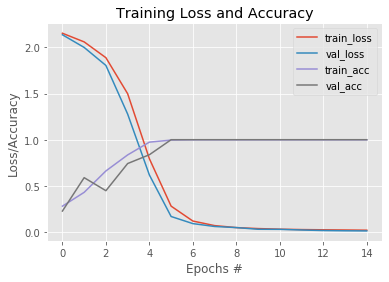

In [12]:
#plot Training/Testing loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 15), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, 15), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, 15), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, 15), H.history['val_acc'], label = 'val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [14]:
#testing captcha breaker
from tensorflow.keras.models import load_model
from imutils import contours

#load pre-trained network
model = load_model('model1.hdf5')

#randomly sample few images
imagePaths = list(paths.list_images('downloads'))
imagePaths = np.random.choice(imagePaths, size = (10, ), replace = False)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
#Breaking the captcha

#loop over the image paths
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray =cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
    
    #threshold image to reveal digits (white digits with black background)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    #find contours in image, keeping only four largest ones and sort from
    #left to right
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, 
                           cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:4]
    cnst = contours.sort_contours(cnts)[0]
    
    #initialize the output image as grayscale image with 3 channels
    output = cv2.merge([gray] * 3)
    predictions = []
    
    
    #loop over the contours
    for c in cnts:
        
        (x, y, w, h) = cv2.boundingRect(c)
        roi = gray[y-5:y+h+5, x-5:x+w+5]
        
        roi = preprocess(roi, 28, 28)
        roi = np.expand_dims(img_to_array(roi), axis = 0)/255.0
        pred = model.predict(roi).argmax(axis = 1)[0] +1 
        predictions.append(str(pred))
        
        #draw predictions on output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, str(pred), (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, 
                   (0, 255, 0), 2)
        
        #show image
        print('captchs: {}'.format(''.join(predictions)))
        cv2.imshow('Output', output)
        cv2.waitKey()

captchs: 8
captchs: 89
captchs: 895
captchs: 8957
captchs: 4
captchs: 43
captchs: 437
captchs: 4375
captchs: 1
captchs: 15
captchs: 157
captchs: 1573
captchs: 9
captchs: 93
captchs: 935
captchs: 9357
captchs: 8
captchs: 84
captchs: 842
captchs: 8422
captchs: 6
captchs: 66
captchs: 661
captchs: 6615
captchs: 8
captchs: 86
captchs: 865
captchs: 8655
captchs: 8
captchs: 88
captchs: 886
captchs: 8861
captchs: 9
captchs: 91
captchs: 915
captchs: 9157
captchs: 8
captchs: 86
captchs: 864
captchs: 8642
